In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

In [245]:
X_train = np.linspace(0,100.,5000)
#y_train = x*np.sin(x) + 2*np.sin(5*x)
y_train = np.sin(X_train)

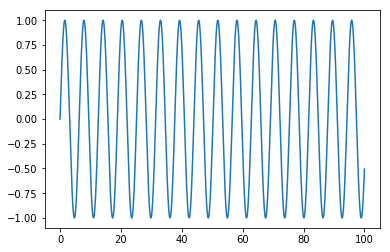

In [246]:
plt.plot(X_train, y_train)

In [247]:
def create_batched_sequence(X_train, y_train, seq_length):
    '''Return a training batch with certain number of X and y pairs.'''
    x_batch_seq = []
    y_batch_seq = []
    
    for i in range(0, len(y_train)-seq_length):
        x_batch_seq.append(X_train[i:i+seq_length])
        y_batch_seq.append(y_train[i+seq_length-1])
        #yield([X_train[i:i+seq_length], y_train[i+seq_length-1]])
    return (x_batch_seq, y_batch_seq)

In [248]:
def get_batch(X_train, y_train, seq_length, batch_size):
    '''Return a training batch with certain number of X and y pairs.'''
    x_batch_seq, y_batch_seq = create_batched_sequence(X_train, y_train, seq_length)

    for i in range(0, len(y_batch_seq), batch_size):   
        id_stop = i+batch_size if i+batch_size < len(y_batch_seq) else len(y_batch_seq)
        X_batch = torch.from_numpy(np.r_[x_batch_seq[i:id_stop]]).float()
        y_batch = torch.from_numpy(np.r_[y_train[i:id_stop]]).float()
        yield(X_batch.t().unsqueeze(2), y_batch)

In [249]:
class nn_LSTM(nn.Module):
    def __init__(self, input_size, seq_length, batch_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, X, hidden):
        _, hidden = self.lstm(X, hidden)
        output = self.out(hidden[0])
        return output, hidden
    
    def initHidden(self):
        return (torch.zeros(1, self.batch_size, self.hidden_size),
                torch.zeros(1, self.batch_size, self.hidden_size)
               )

In [250]:
input_size

1

In [251]:
batch_size = 50
hidden_size = 256
seq_length = 200
input_size = 1
output_size = 1

In [252]:
rnn = nn_LSTM(input_size, seq_length, batch_size, hidden_size, output_size)

In [253]:
rnn

nn_LSTM(
  (lstm): LSTM(1, 256)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

In [254]:
loss_fn = nn.MSELoss()

In [255]:
optimizer  = torch.optim.Adam(rnn.parameters(), lr=0.01)

In [256]:
def train(X_batch, y_batch):
    #from boxx import g
    
    h_prev = rnn.initHidden()
    optimizer.zero_grad()
    y_score = rnn(X_batch, h_prev)[0].squeeze()
    batch_loss = loss_fn(y_score, y_batch)
    batch_loss.backward()
    optimizer.step()

    return y_score, torch.mean(batch_loss)

In [257]:
'''def train(X_batch, y_batch):
    #from boxx import g
    
    h_prev = rnn.initHidden()
    optimizer.zero_grad()
    batch_loss = torch.tensor(0, dtype=torch.float)
    
    for i in range(len(X_batch)):
        #y_score, h_prev = rnn(X_batch[i].view(1,1,-1), h_prev)
        y_score, h_prev = rnn(X_batch.t().unsqueeze(2), h_prev)
        #g()
        loss = loss_fn(y_score.view(1,-1), y_batch[i].view(1, -1))
        batch_loss += loss
    batch_loss.backward()
    optimizer.step()

    return y_score, batch_loss/len(X_batch)'''

'def train(X_batch, y_batch):\n    #from boxx import g\n    \n    h_prev = rnn.initHidden()\n    optimizer.zero_grad()\n    batch_loss = torch.tensor(0, dtype=torch.float)\n    \n    for i in range(len(X_batch)):\n        #y_score, h_prev = rnn(X_batch[i].view(1,1,-1), h_prev)\n        y_score, h_prev = rnn(X_batch.t().unsqueeze(2), h_prev)\n        #g()\n        loss = loss_fn(y_score.view(1,-1), y_batch[i].view(1, -1))\n        batch_loss += loss\n    batch_loss.backward()\n    optimizer.step()\n\n    return y_score, batch_loss/len(X_batch)'

In [258]:
rnn

nn_LSTM(
  (lstm): LSTM(1, 256)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

In [262]:
batch_size

50

In [264]:
all_losses = []
print_every = 100
for epoch in range(2):    
    for batch in get_batch(X_train, y_train, seq_length, batch_size):
        X_batch, y_batch = batch
        _, batch_loss = train(X_batch, y_batch)
        all_losses.append(batch_loss.item())
        if (len(all_losses) >= print_every and len(all_losses) % print_every == 0):
            print(f'----\nRunning Avg Loss:{np.mean(all_losses[-print_every:])} at iter: {len(all_losses)}\n----')
            # log to tensorboard every X iterations. Can be removed if Tensorboard is not installed.
            #writer.add_scalar('loss', np.mean(all_losses[-100:]), len(all_losses))
            # generate text every X iterations
            #print(sample_chars(rnn, X_batch[0], rnn.initHidden(), 200))

In [274]:
X_batch, y_batch = list(get_batch(X_train, y_train, seq_length, 3000))[0]

In [275]:
seq_length

200

In [276]:
X_batch.shape

torch.Size([200, 3000, 1])

In [277]:
h = (torch.zeros(1, 3000, hidden_size), torch.zeros(1, 3000, hidden_size))

In [278]:
y_pred = rnn(X_batch, h)[0].squeeze()

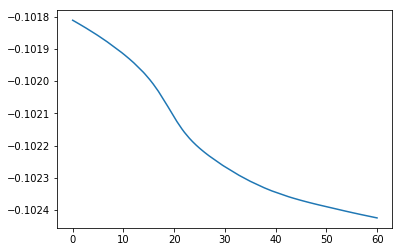

In [279]:
plt.plot(X_train[:3000], y_pred.detach().numpy())

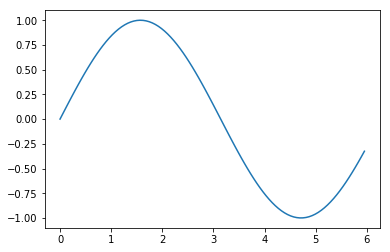

In [244]:
plt.plot(X_train[:100], y_train[:100])